In [10]:
import numpy as np 
import pandas as pd 
from data_processing import generate_vocab, process_data, create_dataloaders
from model import get_pretrained_emb, EncoderRNN, DecoderRNN, DecoderAttnRNN, EncoderDecoder, EncoderDecoderAttn, EncoderCNN, EncoderCNN2, Decoder_RNN_from_CNN, CNN_RNN_EncoderDecoder 
from train_eval import train_and_eval, count_parameters, summarize_results, plot_single_learning_curve, load_experiment_log, plot_multiple_learning_curves
import pickle as pkl 
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# params required for generating data loaders 

SRC_LANG = 'vi'
TARG_LANG = 'en'

SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 
TARG_VOCAB_SIZE = 30000 

BATCH_SIZE = 64 

# takes a long time to process, save to pickle for reimport in future 
#vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
#vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
#pkl.dump(vocab, open(vocab_filename, "wb"))

# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, filter_long=False)
data_minibatch = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=BATCH_SIZE, filter_long=False) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=1000, filter_long=False)

# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

# model architecture params 
NETWORK_TYPE = 'cnn'
RNN_CELL_TYPE = 'gru'
NUM_LAYERS = 1 
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0 #0.2 
DEC_DROPOUT = 0 #0.2 
ATTENTION_TYPE = 'additive'

# training params  
NUM_EPOCHS = 10 #5
LR = 0.0003 # 0.0005
OPTIMIZER = 'Adam'
LAZY_TRAIN = False

# name the model and experiment 
EXPERIMENT_NAME = 'vi_final'
if NETWORK_TYPE == 'rnn': 
    MODEL_NAME = '{}-rnn-{}-attn'.format(SRC_LANG, ATTENTION_TYPE)
elif NETWORK_TYPE == 'cnn': 
    MODEL_NAME = '{}-cnn'.format(SRC_LANG)

# store as dict to save to results later 
params = {'experiment_name': EXPERIMENT_NAME,'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
          'rnn_cell_type': RNN_CELL_TYPE, 'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 
          'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 'src_vocab_size': SRC_VOCAB_SIZE, 
          'targ_vocab_size': TARG_VOCAB_SIZE, 'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 
          'dec_hidden_dim': DEC_HIDDEN_DIM, 'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 
          'clip_grad_max_norm': CLIP_GRAD_MAX_NORM, 'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 
          'attention_type': ATTENTION_TYPE, 'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 
          'learning_rate': LR, 'optimizer': OPTIMIZER, 'lazy_train': LAZY_TRAIN} 


# instantiate model 

encoder = EncoderCNN(pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']), 
                      src_max_sentence_len=10, dropout=0, enc_hidden_dim=params['enc_hidden_dim'])


decoder =  Decoder_RNN_from_CNN(dec_hidden_dim=params['dec_hidden_dim'], enc_hidden_dim=params['enc_hidden_dim'], num_layers=NUM_LAYERS,
                     targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, batch_size=BATCH_SIZE, 
                     pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
model = CNN_RNN_EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device)

In [11]:
# train and eval 
model, results = train_and_eval(
    model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
    params=params, vocab=vocab, print_intermediate=500, save_checkpoint=True, save_to_log=True, 
    lazy_eval=False, print_attn=False, inspect_samples=1)

Epoch: 0.00, Train Loss: 10.26, Val Loss: 10.27, Train BLEU: 0.04, Val BLEU: 0.03, Minutes Elapsed: 0.13
Sampling from training predictions...
Source: đây không_phải bằng chữ hebrew <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: this is not just in hebrew , by the
Model: <SOS> intuitive intuitive intuitive projector herald herald directs directs directs

Sampling from val predictions...
Source: nếu bạn có quyền truy_cập những thông_tin này , bạn
Reference: if you have access to this information , you
Model: <SOS> tunguska intuitive intuitive acquires hubris month month month pick-up



KeyboardInterrupt: 

In [24]:
experiment_results = summarize_results(load_experiment_log(experiment_name=EXPERIMENT_NAME))
print(summarize_results(experiment_results)[['model_name', 'best_val_loss', 'best_val_bleu', 'runtime', 
                                          'total_params', 'trainable_params', 'dt_created']].head(1))

  model_name  best_val_loss  best_val_bleu   runtime  total_params  \
0     vi-cnn       9.948703       0.146936  0.199746      38365404   

   trainable_params           dt_created  
0          20365404  2018-12-14 02:29:18  


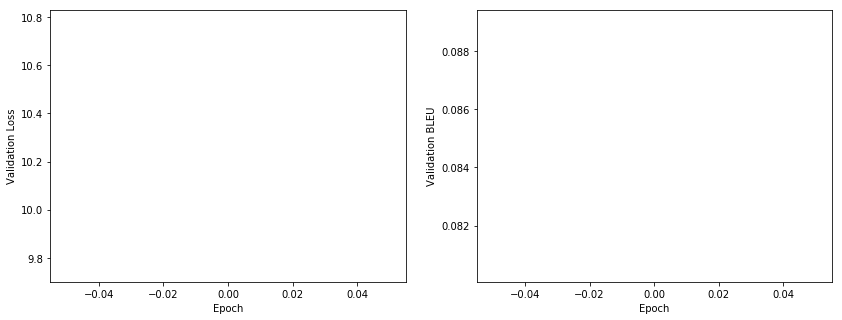

In [21]:
plot_single_learning_curve(experiment_results['results'][0])
plt.savefig('vi_full_model.png')

In [25]:
print(summarize_results(experiment_results)[['model_name', 'best_val_loss', 'best_val_bleu', 'runtime', 
                                          'total_params', 'trainable_params', 'dt_created']].head(1))

  model_name  best_val_loss  best_val_bleu   runtime  total_params  \
0     vi-cnn       9.948703       0.146936  0.199746      38365404   

   trainable_params           dt_created  
0          20365404  2018-12-14 02:29:18  
